In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, Statevector, state_fidelity
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import Parameter # To enable parameterized circuits
from qiskit.circuit.library import SwapGate
from qiskit_aer import AerSimulator

import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from math import pi, sqrt
from matplotlib import pyplot as plt

# 01 (Alice X Gate)

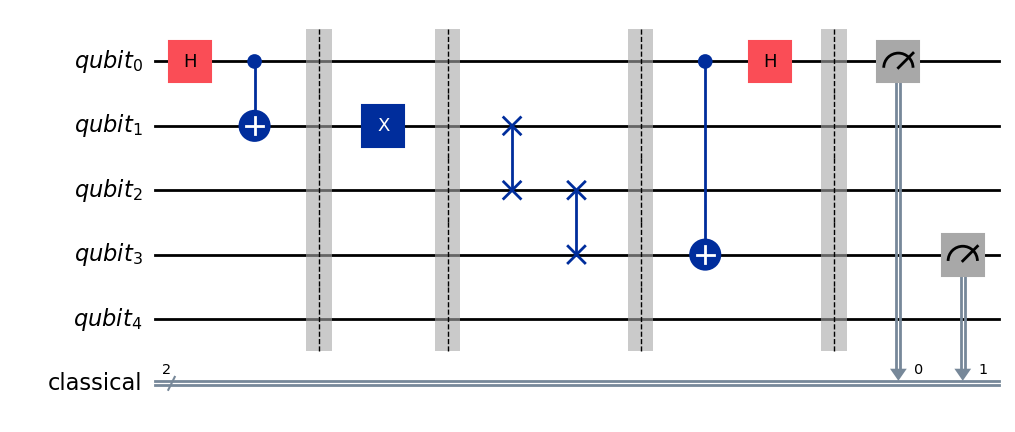

In [12]:
bNum = 2

xTheta = Parameter('xTheta')
yTheta = Parameter('yTheta')
zTheta = Parameter('zTheta')

param_sets = [
    {zTheta: 0,     yTheta: 0,     xTheta: 0},          # Identity (I)
    {zTheta: 0,     yTheta: pi/2,     xTheta: pi},       # X basis
    {zTheta: pi/2,     yTheta: pi/2, xTheta: pi},           # Y basis
    {zTheta: 0, yTheta: 0,     xTheta: 0},           # Z basis
]

num_data_qubits = 5
num_data_cbits = 2

# Create qubit and classical data bit registers (you can create and name additional registers if it's useful for bookkeeping)
data_qubits = QuantumRegister(num_data_qubits, "qubit")
classical_data = ClassicalRegister(num_data_cbits, "classical")

# Create circuit object
qc = QuantumCircuit(data_qubits,  classical_data)

# Create empty lists to store qubits and classical bits for convenient access
qdata = []; cdata = []; 

# Store qubits from data_qubit register in list for convenient access
qdata[:] = data_qubits

# Store classical bits from classical_data register in list for convenient access
cdata[:] = classical_data
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.h(0) #This is state to be transported
qc.cx(0,1)
qc.barrier()

qc.x(1)
qc.barrier()

for i in range (1, bNum + 1):
    qc.swap(i, i+1)
qc.barrier()

qc.cx(0, bNum + 1)
qc.h(0)
qc.barrier()

qc.measure(0, 0)
qc.measure(bNum + 1, 1)


qc.draw('mpl')

In [16]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend = FakeSherbrooke()
sampler = Sampler(backend)

# Create the "pass manager" that will perform the transpilation
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)

# Run the pass manager to generate the transpiled circuit
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw('mpl')

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/opt/conda/lib/python3.11/site-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/opt/conda/lib/python3.11/site-packages/qiskit/providers/__init__.py)


VisualizationError: 'Invalid output type transpiled_circuit selected. The only valid choices are text, latex, latex_source, and mpl'

In [15]:
job2 = sampler.run([transpiled_circuit])